In [1]:
# set multi print in one cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import mxnet as mx
import numpy as np 
from pprint import pprint 
import cmath

In [8]:
class Softmax(mx.operator.CustomOp):
    def forward(self,is_train, req, in_data, out_data, aux):
#         x = in_data[0].asnumpy()
#         y = np.exp( x-x.max(axis=1).reshape((-1,1))  ) 
#         y /= y.sum(axis=1).reshape((-1,1))
        x = in_data[0]
        x_max = mx.nd.max(x,axis=1)
        x_max = mx.nd.reshape(x_max,(x_max.shape[0],1))
        y = mx.nd.power(cmath.e, x-x_max)
        y_sum = mx.nd.sum(y,axis=1)
        y_sum = mx.nd.reshape(y_sum,(y_sum.shape[0],1))
        y = y/ y_sum 
        
        self.assign(out_data[0], req[0], y )
        return 
    
    def backward(self, req, out_grad, in_data, out_data, in_grad, aux):
        l = in_data[1].asnumpy().ravel().astype(int)
        y = out_data[0].asnumpy()
#         print {'l':l}
#         print {'y':y}
        y[np.arange(l.shape[0]), l] -= 1.0
        self.assign(in_grad[0],req[0],mx.nd.array(y))
        return


@mx.operator.register('softmaxSelf')
class SoftmaxProp(mx.operator.CustomOpProp):
    def __init__(self):
        super(SoftmaxProp, self).__init__(need_top_grad = False) 
    def list_arguments(self):
        return ['data', 'label']
    def list_outputs(self):
        return ['output']
    def infer_shape(self, in_shape):
        data_shape = in_shape[0]
        label_shape = (in_shape[0][0],)
        output_shape = in_shape[0]
        return [data_shape, label_shape], [output_shape], []

    def create_operator(self,ctx, shapes, dtypes):
        return Softmax()
    


[('data', (10L, 5L)), ('out_label', (10L,)), ('out_output', (10L, 5L))]


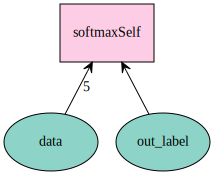

['data', 'out_label']

In [3]:
# toy example 
def get_sym():
    data = mx.sym.Variable('data')
    label = mx.sym.Variable('label')
    out = mx.symbol.Custom(data=data,name='out',op_type='softmaxSelf')
    return out 

net = get_sym()
batch_size = 10
num_class = 5
data_shape_dict = {'data':(batch_size,num_class)}
net_all = net.get_internals()
arg_shape, out_shape, aux_shape = net_all.infer_shape(**data_shape_dict)
pprint( zip(net_all.list_outputs(),out_shape))
mx.viz.plot_network(net, shape= data_shape_dict)
net.list_arguments()

In [10]:
# using executor to check result  
data = mx.nd.array(np.arange(5).reshape((1,-1)) )
label = mx.nd.ones(1)*2
ctx = mx.cpu()
shape_dict = {'data':data.shape, 'out_label':label.shape}
ex = net.simple_bind(ctx = ctx, **shape_dict)
ex.arg_dict['data'][:] = data
ex.arg_dict['out_label'][:]=label
ex.forward(is_train=True)

[<NDArray 1x5 @cpu(0)>]

In [11]:
ex.backward()

In [12]:
net.list_outputs(), ex.outputs[0].asnumpy()

(['out_output'],
 array([[ 0.01165623,  0.03168492,  0.08612856,  0.23412167,  0.63640863]], dtype=float32))

In [13]:
ex.grad_dict['data'].asnumpy()

array([[ 0.01165623,  0.03168492, -0.91387147,  0.23412167,  0.63640863]], dtype=float32)

In [9]:
cmath.e

2.718281828459045

In [ ]:
?mx.nd.reshape